In [4]:
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import ssl
from datetime import timedelta

### Step 1: Load and inspect the data

In [8]:
df = pd.read_csv('btc_news.csv') 
print(df.head())
df.tail()

   Unnamed: 0   begins_at  open_price  close_price  high_price  low_price  \
0           0  2018-02-25    9680.200     9584.450    9864.640    9300.02   
1           1  2018-02-26    9592.495    10318.785   10452.515    9378.91   
2           2  2018-02-27   10318.785    10548.385   10861.010   10140.93   
3           3  2018-02-28   10552.470    10314.965   11058.680   10271.26   
4           4  2018-03-01   10314.965    10950.900   11087.430   10226.54   

  symbol                                           articles  
0    BTC  ['Original Pizza Day Purchaser Does It Again W...  
1    BTC  ['Bitcoin Pizza Day 2: How A Lightning Payment...  
2    BTC  ['Rapper 50 Cent, Who Bragged About Owning Bit...  
3    BTC  ['This Is Who Controls Bitcoin', 'British Man ...  
4    BTC  ['Bitcoin makes inroads in LA’s residential re...  


,Unnamed: 0,begins_at,open_price,close_price,high_price,low_price,symbol,articles
1821,1821,2023-02-20,24280.247321,24853.059903,25123.529442,23844.178711,BTC,['Bitcoin regains $25K amid hope record China ...
1822,1822,2023-02-21,24853.079620,24456.669930,25275.238494,24152.001328,BTC,['Bitcoin active addresses ‘concern’ analyst d...
1823,1823,2023-02-22,24456.669930,24188.001674,24481.768911,23579.102697,BTC,"['Bitcoin, Ethereum Technical Analysis: BTC Fa..."
1824,1824,2023-02-23,24188.001674,23945.184405,24602.443871,23609.304217,BTC,['Bitcoin bears attempt to pin BTC price under...
1825,1825,2023-02-24,23945.403897,23185.716258,24136.008408,22816.693229,BTC,['Bitcoin on-chain data highlights key similar...


As we can see we have data from 2018-02-25 to 2023-02-24

### Step 2: Sentiment Analysis on Articles

First of all it is important to understund article throught sentiment. So we created a function that will hlp us do that

Important step you need to download vader_lexicon.txt. Here is a link to it
https://github.com/nltk/nltk_data/blob/gh-pages/packages/sentiment/vader_lexicon.zip

How We Calculate the Sentiment Parameter
- Collect Daily Articles: For each date in the dataset, we have a list of articles.
- Apply VADER: The VADER sentiment analyzer assigns a compound sentiment score to each piece of text. This score ranges from -1 (most negative) to +1 (most positive).
- Average Daily Score: We take all the articles from a given day, score each one, and then average these scores to get a single daily sentiment value.
- Incorporate into Model Features: This daily sentiment score is merged with the price and volatility data. It becomes an additional input feature for our model, potentially allowing the model to associate changes in sentiment with subsequent price movements.

In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('vader_lexicon', force=True)
sia = SentimentIntensityAnalyzer(lexicon_file='/Users/ulapalijcuk/Downloads/vader_lexicon/vader_lexicon.txt')

def get_daily_sentiment(articles_list):
    if not articles_list:
        return 0
    if isinstance(articles_list, str):
        import ast
        articles_list = ast.literal_eval(articles_list)
    
    scores = []
    for art in articles_list:
        score = sia.polarity_scores(art)['compound']
        scores.append(score)
    if len(scores) > 0:
        return np.mean(scores)
    return 0

df['sentiment'] = df['articles'].apply(get_daily_sentiment)

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


### Step 3: Feature Engineering

In [ ]:
df['return'] = df['close_price'].pct_change()
df['volatility_7d'] = df['close_price'].pct_change().rolling(window=7).std()
df = df.dropna()
df['target'] = df['close_price'].shift(-1)
df = df.dropna()

features = ['close_price', 'return', 'volatility_7d', 'sentiment']
target = ['target']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features+target] = scaler.fit_transform(df[features+target])

14     -0.07334
15     -0.17714
16      0.12105
17     -0.13456
18     -0.07532
         ...   
1819    0.15925
1820    0.02141
1821   -0.00855
1822    0.12380
1823   -0.00937
Name: sentiment, Length: 1810, dtype: float64

### Step 4: Preparing for LSTM

Let's start with creating sequence


In [ ]:
lookback = 30

def create_sequences(data, features, target, lookback=30):
    X, y = [], []
    feat_data = data[features+target].values
    for i in range(len(feat_data) - lookback):
        X.append(feat_data[i:i+lookback, :-1])
        y.append(feat_data[i+lookback, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, features, target, lookback=lookback)

Now let's split data 80% for training and 20% for validation. We will test our model in the price prediction in the next year

In [23]:
split_index = int(len(df) * 0.8)

X_train, X_test = X[:split_index-lookback], X[split_index-lookback:]
y_train, y_test = y[:split_index-lookback], y[split_index-lookback:]

### Step 5: Train LSTM Model

In [24]:
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0361 - val_loss: 0.0094
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 0.0043


### Step 6: Evaluate Model

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test RMSE: 2083.1181209402857


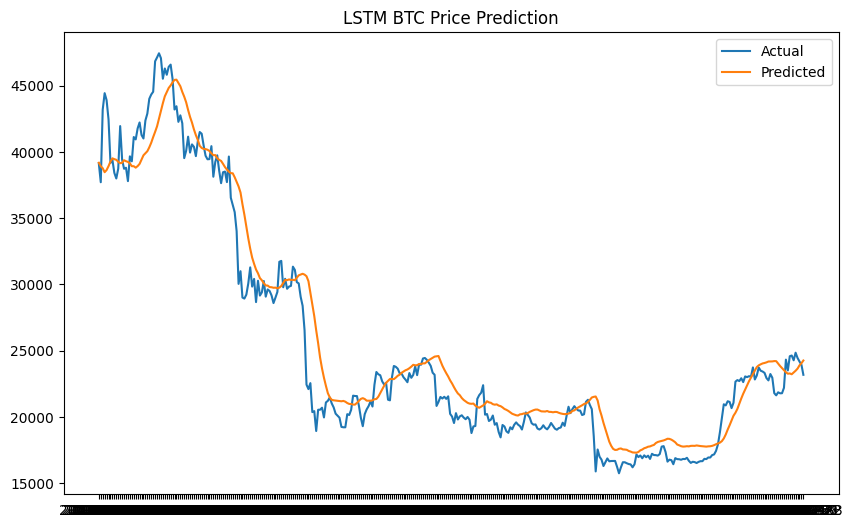

In [ ]:
y_pred = model.predict(X_test)
test_data_for_inv = np.zeros((len(y_test), len(features)+1))
test_data_for_inv[:,:-1] = X_test[:,-1,:]
test_data_for_inv[:,-1] = y_pred.flatten()
pred_inv = scaler.inverse_transform(test_data_for_inv)[:,-1]

test_data_for_inv_target = np.zeros((len(y_test), len(features)+1))
test_data_for_inv_target[:,:-1] = X_test[:,-1,:]
test_data_for_inv_target[:,-1] = y_test
y_test_inv = scaler.inverse_transform(test_data_for_inv_target)[:,-1]

rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
print("Test RMSE:", rmse)

plt.figure(figsize=(10,6))
plt.plot(df['begins_at'].iloc[split_index:split_index+len(y_test_inv)], y_test_inv, label='Actual')
plt.plot(df['begins_at'].iloc[split_index:split_index+len(y_test_inv)], pred_inv, label='Predicted')
plt.legend()
plt.title("LSTM BTC Price Prediction")
plt.show()

### Step 7: Forecast Next Month and Year
Now let's build forecast and then compare it with actual prices. we will use a rolling prediction approach, starting from last available window and predict forward.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

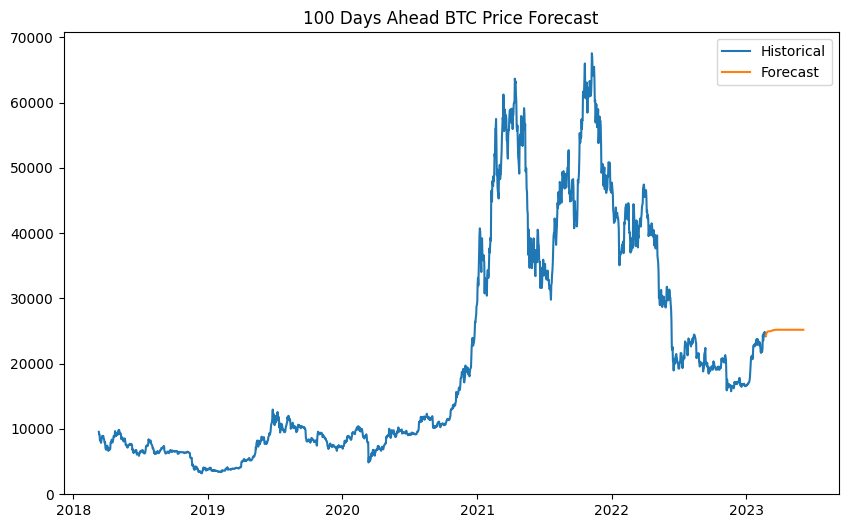

Forecasted price on 2023-06-05: 25183.391824541093


In [ ]:
forecast_days = 103
current_window = X_test[-1].copy()
predictions = []

for _ in range(forecast_days):
    X_input = current_window[np.newaxis, :, :]
    pred_scaled = model.predict(X_input)
    last_features = current_window[-1, :]
    inv_input = np.zeros((1, len(features) + 1))
    inv_input[0, :-1] = last_features
    inv_input[0, -1] = pred_scaled[0, 0]
    next_close_price = scaler.inverse_transform(inv_input)[0, -1]
    predictions.append(next_close_price)
    new_row = last_features.copy()
    new_row[-1] = pred_scaled[0, 0]
    current_window = np.vstack([current_window[1:], new_row])

last_date = df['begins_at'].iloc[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

plt.figure(figsize=(10,6))
plt.plot(df['begins_at'], df['close_price'], label='Historical')
plt.plot(future_dates, predictions, label='Forecast')
plt.legend()
plt.title("100 Days Ahead BTC Price Forecast")
plt.show()

final_forecast_date = future_dates[-1]
final_forecast_price = predictions[-1]

print(f"Forecasted price on {final_forecast_date.strftime('%Y-%m-%d')}: {final_forecast_price}")



The real price of Bitcoin in 2023-06-05 was $25,762.18, which is insanely high precise and means that our model is really good.